In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from data_utils_batch import *

In [3]:
# Hyperparameter
batch_size = 20
lambda_g = 100.
lambda_c = 10.
learning_rate_gen = 5e-5
learning_rate_dis = 5e-5
max_step = 20000
n_dis = 5
# lambda (gradient panelty)
lam = 10.

In [4]:
# X -> Y
def gen_G(x, reuse = False):
    
    # x: original image
    with tf.variable_scope('gen_G', reuse = reuse):
        '''
        fc1 = tf.layers.dense(z,
                              units = 96 * 96 * 13,
                              activation = tf.nn.leaky_relu)
        fc1 = tf.layers.batch_normalization(fc1)
        fc1 = tf.reshape(fc1, [-1, 96, 96, 13])
        
        data = tf.concat([fc1, x], axis = 3)
        '''
        
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        
        conv1 = tf.layers.batch_normalization(conv1)
        
        # conv2: 24 * 24 * 128
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 128,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # conv3: 12 * 12 * 256
        conv3 = tf.layers.conv2d(conv2,
                                 filters = 256,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv3 = tf.layers.batch_normalization(conv3)
        
        # deconv1: 24 * 24 * 256
        deconv1 = tf.layers.conv2d_transpose(conv3,
                                             filters = 128,
                                             kernel_size = 5,
                                             strides = 2,
                                             padding = 'same',
                                             activation = tf.nn.leaky_relu)
        deconv1 = tf.layers.batch_normalization(deconv1)
        deconv1 = tf.concat([deconv1, conv2], axis = 3)
        
        # deconv2: 48 * 48 * 128
        deconv2 = tf.layers.conv2d_transpose(deconv1,
                                             filters = 64,
                                             kernel_size = 5,
                                             strides = 2,
                                             padding = 'same',
                                             activation = tf.nn.leaky_relu)
        deconv2 = tf.layers.batch_normalization(deconv2)
        deconv2 = tf.concat([deconv2, conv1], axis = 3)
        
        # output: 96 * 96 * 3
        output = tf.layers.conv2d_transpose(deconv2,
                                             filters = 3,
                                             kernel_size = 5,
                                             strides = 2,
                                             padding = 'same',
                                             activation = tf.nn.tanh)
        return output

# noise_input = tf.placeholder(tf.float32, shape = [None, z_dim])
# gen_input = tf.placeholder(tf.float32, shape = [None, 96, 96, 3])
# print (gen_G(gen_input))

In [5]:
# Y -> X
def gen_F(x, reuse = False):
    # x: target image
    with tf.variable_scope('gen_F', reuse = reuse):
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        
        conv1 = tf.layers.batch_normalization(conv1)
        
        # conv2: 24 * 24 * 128
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 128,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # conv3: 12 * 12 * 256
        conv3 = tf.layers.conv2d(conv2,
                                 filters = 256,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv3 = tf.layers.batch_normalization(conv3)
        
        # deconv1: 24 * 24 * 256
        deconv1 = tf.layers.conv2d_transpose(conv3,
                                             filters = 128,
                                             kernel_size = 5,
                                             strides = 2,
                                             padding = 'same',
                                             activation = tf.nn.leaky_relu)
        deconv1 = tf.layers.batch_normalization(deconv1)
        deconv1 = tf.concat([deconv1, conv2], axis = 3)
        
        # deconv2: 48 * 48 * 128
        deconv2 = tf.layers.conv2d_transpose(deconv1,
                                             filters = 64,
                                             kernel_size = 5,
                                             strides = 2,
                                             padding = 'same',
                                             activation = tf.nn.leaky_relu)
        deconv2 = tf.layers.batch_normalization(deconv2)
        deconv2 = tf.concat([deconv2, conv1], axis = 3)
        
        # output: 96 * 96 * 3
        output = tf.layers.conv2d_transpose(deconv2,
                                             filters = 3,
                                             kernel_size = 5,
                                             strides = 2,
                                             padding = 'same',
                                             activation = tf.nn.tanh)
        return output


# sample = tf.placeholder(tf.float32, shape = [None, 96, 96, 3])
# print (gen_F(sample))

In [6]:
# distinguish original images and recovered images
def dis_X(x, reuse = False):
    with tf.variable_scope('dis_X', reuse = reuse):
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        # conv2: 24 * 24 * 64
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # conv3: 12 * 12 * 64
        conv3 = tf.layers.conv2d(conv2,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv3 = tf.layers.batch_normalization(conv3)
        conv3 = tf.layers.flatten(conv3)
        
        # fc1: 128 units
        fc1 = tf.layers.dense(conv3, 
                              units = 128,
                              activation = tf.nn.relu)
        fc2 = tf.layers.dense(fc1,
                              units = 10,
                              activation = tf.nn.relu)
        output = tf.layers.dense(fc2,
                                units = 1)
        return output

# sample = tf.placeholder(tf.float32, shape = [None, 96, 96, 3])
# print (dis_X(sample, reuse = False))

In [7]:
# distinguish generated images and target images
def dis_Y(x, reuse = False):
    with tf.variable_scope('dis_Y', reuse = reuse):
        
        # conv1: 48 * 48 * 64
        conv1 = tf.layers.conv2d(x,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        # conv2: 24 * 24 * 64
        conv2 = tf.layers.conv2d(conv1,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)
        
        # conv3: 12 * 12 * 64
        conv3 = tf.layers.conv2d(conv2,
                                 filters = 64,
                                 kernel_size = 5,
                                 strides = 2,
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv3 = tf.layers.batch_normalization(conv3)
        conv3 = tf.layers.flatten(conv3)
        
        # fc1: 128 units
        fc1 = tf.layers.dense(conv3, 
                              units = 128,
                              activation = tf.nn.relu)
        fc2 = tf.layers.dense(fc1,
                              units = 10,
                              activation = tf.nn.relu)
        output = tf.layers.dense(fc2,
                                units = 1)
        return output
    
# sample = tf.placeholder(tf.float32, shape = [None, 96, 96, 3])
# print (dis_Y(sample, reuse = False))

In [8]:
# Input

true_X = tf.placeholder(tf.float32, shape = [None, 96, 96, 3])
true_Y = tf.placeholder(tf.float32, shape = [None, 96, 96, 3])

fake_Y = gen_G(true_X)
recover_X = gen_F(fake_Y)
fake_X = gen_F(true_Y, reuse = True)
recover_Y = gen_G(fake_X, reuse = True)

# Logits
Y_true_logit = dis_Y(true_Y)
Y_fake_logit = dis_Y(fake_Y, reuse = True)
X_true_logit = dis_X(true_X)
X_fake_logit = dis_X(fake_X, reuse = True)

# Variables
gen_G_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='gen_G')
gen_F_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='gen_F')
dis_X_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='dis_X')
dis_Y_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='dis_Y')

# Loss

## Adversial Loss
dis_X_loss = tf.reduce_mean(X_fake_logit - X_true_logit)
dis_Y_loss = tf.reduce_mean(Y_fake_logit - Y_true_logit)
gen_G_loss = tf.reduce_mean(- Y_fake_logit)
gen_F_loss = tf.reduce_mean(- X_fake_logit)

## Cycle Consistency Loss
gen_G_loss += lambda_c * tf.reduce_mean(tf.abs(recover_X - true_X)) + lambda_c * tf.reduce_mean(tf.abs(recover_Y - true_Y))
gen_F_loss += lambda_c * tf.reduce_mean(tf.abs(recover_X - true_X)) + lambda_c * tf.reduce_mean(tf.abs(recover_Y - true_Y))

## Gradient Panelty Loss

### Interpolated Sample
uniform_dist = tf.contrib.distributions.Uniform(low=0., high=1.)

alpha_X = uniform_dist.sample((batch_size, 1, 1, 1))
inter_X = true_X + alpha_X * (fake_X - true_X)

alpha_Y = uniform_dist.sample((batch_size, 1, 1, 1))
inter_Y = true_Y + alpha_Y * (fake_Y - true_Y)

### Gradients
inter_X_logit = dis_X(inter_X, reuse = True)
grad_X = tf.gradients(inter_X_logit, [inter_X, ])[0]
grad_X_l2 = tf.sqrt(tf.reduce_sum(tf.square(grad_X), axis = [1, 2, 3]))
gp_X = tf.reduce_mean((grad_X_l2 - 1) ** 2)
dis_X_loss += lambda_g * gp_X

inter_Y_logit = dis_Y(inter_Y, reuse = True)
grad_Y = tf.gradients(inter_Y_logit, [inter_Y, ])[0]
grad_Y_l2 = tf.sqrt(tf.reduce_sum(tf.square(grad_Y), axis = [1, 2, 3]))
gp_Y = tf.reduce_mean((grad_Y_l2 - 1) ** 2)
dis_Y_loss += lambda_g * gp_Y

# Optimizer
gen_G_opt = tf.train.AdamOptimizer(learning_rate_gen).minimize(gen_G_loss, var_list = gen_G_var)
gen_F_opt = tf.train.AdamOptimizer(learning_rate_gen).minimize(gen_F_loss, var_list = gen_F_var)
dis_X_opt = tf.train.AdamOptimizer(learning_rate_dis).minimize(dis_X_loss, var_list = dis_X_var)
dis_Y_opt = tf.train.AdamOptimizer(learning_rate_dis).minimize(dis_Y_loss, var_list = dis_Y_var)

# Initialization
init = tf.global_variables_initializer()

Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
reload = True
reload_dir = '../model_2018_09_19/my-model-19800'

In [10]:
data_X = dataReader('../data/lfw/')
data_Y = dataReader('../data/animate/')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not reload:

    for i in range(max_step):
        for j in range(n_dis):
            batch_x = data_X.next_batch(batch_size)
            batch_y = data_Y.next_batch(batch_size)

            feed_dict = {true_X: batch_x, true_Y: batch_y}
            sess.run([dis_X_opt, dis_Y_opt], feed_dict = feed_dict)

        batch_x = data_X.next_batch(batch_size)
        batch_y = data_Y.next_batch(batch_size)

        feed_dict = {true_X: batch_x, true_Y: batch_y}
        _, _, x_loss, y_loss, g_loss, f_loss, x_gp, y_gp = sess.run([gen_G_opt, gen_F_opt, dis_X_loss, dis_Y_loss, gen_G_loss, gen_F_loss, gp_X, gp_Y], feed_dict = feed_dict)
        if i % 200 == 0:
            print ('step {}: {}, {}, {}, {}, {}, {}'.format(i, x_loss, y_loss, g_loss, f_loss, x_gp, y_gp))
else:
    
    saver = tf.train.Saver()
    saver = tf.train.import_meta_graph(reload_dir + '.meta')
    saver.restore(sess, reload_dir)


INFO:tensorflow:Restoring parameters from ../model_2018_09_19/my-model-19800


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


"\n\nresult_dir = '../result/'\n\ncnt = 0\n\nfor i in range(10):\n    batch_x = data_X.next_batch(10)\n    g = sess.run(fake_Y, feed_dict = {true_X: batch_x})\n    g = (g + 1) * 127.5\n    batch_x = (batch_x + 1) * 127.5\n    for j in range(10):\n        cv2.imwrite(result_dir + 'origin_{}.jpg'.format(str(cnt).zfill(4)), batch_x[j])\n        cv2.imwrite(result_dir + 'transfer_{}.jpg'.format(str(cnt).zfill(4)), g[j])\n        cnt += 1\n"

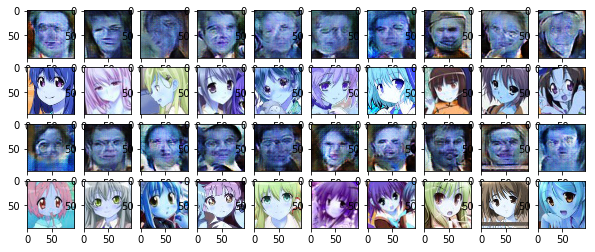

In [11]:
'''
# Generate images from noise, using the generator network.
f, a = plt.subplots(4, 10, figsize=(10, 4))
for i in range(10):
    
    
    batch_x = data_X.next_batch(4)
    
    g = sess.run(fake_Y, feed_dict={true_X: batch_x})
    g = (g + 1) / 2
    batch_x = (batch_x + 1) / 2
    for j in range(2):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        #img = np.reshape(np.xxxxxxrepeat(g[j][:, :, np.newaxis], 3, axis=2),
        #                 newshape=(28, 28, 3))
        a[j * 2][i].imshow(g[j])
        a[j * 2 + 1][i].imshow(batch_x[j])

f.show()
plt.draw()
'''
f, a = plt.subplots(4, 10, figsize=(10, 4))
for i in range(10):
    
    
    batch_y = data_Y.next_batch(4)
    
    g = sess.run(fake_X, feed_dict={true_Y: batch_y})
    g = (g + 1) / 2
    batch_y = (batch_y + 1) / 2
    for j in range(2):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        #img = np.reshape(np.xxxxxxrepeat(g[j][:, :, np.newaxis], 3, axis=2),
        #                 newshape=(28, 28, 3))
        a[j * 2][i].imshow(g[j])
        a[j * 2 + 1][i].imshow(batch_y[j])

f.show()
plt.draw()

'''

result_dir = '../result/'

cnt = 0

for i in range(10):
    batch_x = data_X.next_batch(10)
    g = sess.run(fake_Y, feed_dict = {true_X: batch_x})
    g = (g + 1) * 127.5
    batch_x = (batch_x + 1) * 127.5
    for j in range(10):
        cv2.imwrite(result_dir + 'origin_{}.jpg'.format(str(cnt).zfill(4)), batch_x[j])
        cv2.imwrite(result_dir + 'transfer_{}.jpg'.format(str(cnt).zfill(4)), g[j])
        cnt += 1
'''        